# Import libraries and read data

In [1]:
import logging
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)
from time import time
from pandas import DataFrame, concat
from seaborn import lineplot
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from torch import cuda
from lightning import Trainer
from lightning.pytorch.loggers import CSVLogger
from ideal_init.lightning_model import NNClassifier, merge_logs

# Define training parameters
BATCH_SIZE = 128
LEARNING_RATE = 1e-1
HIDDEN_SIZES = (10,)
DIRECTORY = "./"
EPOCHS = 10

def experiment_data():
    X, y = load_iris(return_X_y=True)
    # Split data: 70% train, 10% validation, 20% test
    X, X_test, y, y_test = train_test_split(X, y, test_size=0.2)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.125)
    return X_train, y_train, X_val, y_val, X_test, y_test

# Run experiments and measure performance

Running experiment 1
Running experiment 2
Running experiment 3
Running experiment 4
Running experiment 5
Running experiment 6
Running experiment 7
Running experiment 8
Running experiment 9
Running experiment 10
Mean values:
IDEAL_acc_before_train    0.5133
IDEAL_acc_after_train     0.6366
IDEAL_init_time           0.0038
IDEAL_train_time          2.0156
He_acc_before_train       0.2033
He_acc_after_train        0.5166
He_init_time              0.0001
He_train_time             2.0242
dtype: object
Confidence error:
IDEAL_acc_before_train    0.0561
IDEAL_acc_after_train     0.0725
IDEAL_init_time           0.0010
IDEAL_train_time          0.0210
He_acc_before_train       0.1365
He_acc_after_train        0.1381
He_init_time              6.6707
He_train_time             0.0180
dtype: object


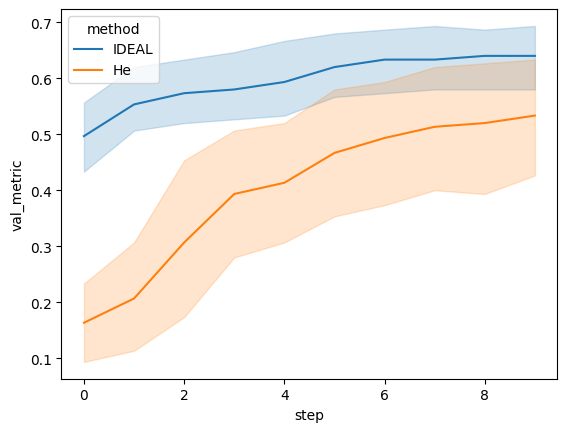

In [2]:
# keep record of the results of all the iterations
values=["IDEAL_acc_before_train", "IDEAL_acc_after_train", "IDEAL_init_time", "IDEAL_train_time", "He_acc_before_train", "He_acc_after_train", "He_init_time", "He_train_time"]
results = {value: [] for value in values}
all_logs = DataFrame()

# repeat experiment multiple times
NUM_EXPERIMENTS = 10
for experiment in range(NUM_EXPERIMENTS):

    print(f"Running experiment {experiment+1}")
    X_train, y_train, X_val, y_val, X_test, y_test = experiment_data()

    # Create models
    init_model = NNClassifier(X_train, y_train, X_val, y_val, X_test, y_test, initialize=True, hidden_sizes=HIDDEN_SIZES, learning_rate=LEARNING_RATE, batch_size=BATCH_SIZE)
    no_init_model = NNClassifier(X_train, y_train, X_val, y_val, X_test, y_test, initialize=False, hidden_sizes=HIDDEN_SIZES, learning_rate=LEARNING_RATE, batch_size=BATCH_SIZE)

    # Create trainers
    init_trainer = Trainer(default_root_dir=DIRECTORY, accelerator="auto", devices="auto", max_epochs=EPOCHS, logger=CSVLogger(save_dir=DIRECTORY), enable_checkpointing=False, enable_progress_bar=False, enable_model_summary=False, val_check_interval=1, log_every_n_steps=1, limit_val_batches=1, precision=64)
    no_init_trainer = Trainer(default_root_dir=DIRECTORY, accelerator="auto", devices="auto", max_epochs=EPOCHS, logger=CSVLogger(save_dir=DIRECTORY), enable_checkpointing=False, enable_progress_bar=False, enable_model_summary=False, val_check_interval=1, log_every_n_steps=1, limit_val_batches=1, precision=64)

    # Test models before training
    results["IDEAL_acc_before_train"].append(init_trainer.test(init_model, verbose=False)[0]["test_metric"])
    results["He_acc_before_train"].append(no_init_trainer.test(no_init_model, verbose=False)[0]["test_metric"])

    # Train models and plot training comparison
    init_time = time()
    init_trainer.validate(init_model)
    init_trainer.fit(init_model)
    init_time = time() - init_time
    init_model_logs = f"{init_trainer.logger.log_dir}/metrics.csv"

    no_init_time = time()
    no_init_trainer.validate(no_init_model)
    no_init_trainer.fit(no_init_model)
    no_init_time = time() - no_init_time
    no_init_model_logs = f"{no_init_trainer.logger.log_dir}/metrics.csv"

    logs = merge_logs(init_model_logs, no_init_model_logs)

    # Test models after training
    results["IDEAL_acc_after_train"].append(init_trainer.test(init_model, verbose=False)[0]["test_metric"])
    results["He_acc_after_train"].append(no_init_trainer.test(no_init_model, verbose=False)[0]["test_metric"])

    # Init and train times
    results["IDEAL_init_time"].append(init_model.init_time)
    results["IDEAL_train_time"].append(init_time)
    results["He_init_time"].append(no_init_model.init_time)
    results["He_train_time"].append(no_init_time)

    # store logs
    all_logs = concat([all_logs, logs])

    #clear cache
    del init_model
    del no_init_model
    cuda.empty_cache()

results = DataFrame(results)
mean = results.mean()
error = results.sem()*1.96
print("Mean values:")
print(mean.astype(str).apply(lambda x: x[:6]))
print("Confidence error:")
print(error.astype(str).apply(lambda x: x[:6]))
lineplot(all_logs, x="step", y="val_metric", hue="method");